# Implementing Grid Search CV on CatBoost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns

In [2]:
ordinal = pd.read_csv('../../Data/BaseOrdinal.csv')
ordinal.sample(3)

,Unnamed: 0,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,...,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
2487,2487,3,3,4,3,3,3,8,4,1,...,0.0,1064.0,0.0,319.0,1383.0,1.0,0.0,1954.0,1.0,354.0
581,581,4,3,5,3,5,4,8,4,2,...,352.0,1359.0,0.0,479.0,1838.0,1.0,0.0,2007.0,2.0,524.0
979,979,3,3,3,3,3,3,8,4,1,...,0.0,0.0,0.0,570.0,570.0,0.0,0.0,1948.0,1.0,249.0


In [3]:
ordinal = ordinal.drop(['Unnamed: 0'], axis=1)
ordinal.shape

(2580, 80)

In [4]:
X = ordinal.drop(['SalePrice'], axis=1)
y = ordinal.SalePrice

In [5]:
cb = CatBoostRegressor(random_state=1, verbose=False, iterations=100)

In [6]:
cb.get_params()

{'iterations': 100,
 'loss_function': 'RMSE',
 'verbose': False,
 'random_state': 1}

## Implementing Grid Search CV with Nested K-Fold

In [7]:
from sklearn.model_selection import GridSearchCV

cv_outer = RepeatedKFold(n_splits=7, random_state=7, n_repeats=1)
cv_inner = RepeatedKFold(n_splits=3, random_state=7, n_repeats=1)
params_cb = {'depth':[6, 8],
             'learning_rate':[0.05, 0.1]}
outer_results = list()

for train_ix, test_ix in cv_outer.split(X,y):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    search = GridSearchCV(estimator=cb, param_grid=params_cb, cv=cv_inner)
    result = search.fit(X_train, y_train)
    print(result.best_params_, result.best_estimator_.score(X_test, y_test))
    outer_results.append(result.best_estimator_.score(X_test, y_test))
 
print(np.mean(outer_results))

{'depth': 8, 'learning_rate': 0.1} 0.9331915101214747
{'depth': 6, 'learning_rate': 0.1} 0.8943260045714295
{'depth': 8, 'learning_rate': 0.1} 0.9168310353786675
{'depth': 6, 'learning_rate': 0.1} 0.9167747113319545
{'depth': 6, 'learning_rate': 0.1} 0.9377472099986582
{'depth': 8, 'learning_rate': 0.1} 0.8976278948551248
{'depth': 6, 'learning_rate': 0.1} 0.8536916933945304
0.9071700085216915


In [8]:
# Use cross-validation to evaluate model performance

def evaluate_model(model, X, y):
    
    # define the evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    # evaluate the model and collect the results
    scores = cross_validate(model, X, y, cv=cv, n_jobs=-1)
    
    #scores = cross_validate(model, X, y, scoring=scoring, 
    #                              cv=cv, n_jobs=-1) 
    
    df = pd.DataFrame(scores)
    
    return df

In [9]:
cb_gs = CatBoostRegressor(random_state=1, depth=6, learning_rate=0.1)

In [10]:
CAT_GS = evaluate_model(cb_gs, X, y)

0:	learn: 69544.4530794	total: 63ms	remaining: 1m 2s
1:	learn: 65689.3101790	total: 71ms	remaining: 35.4s
2:	learn: 61314.7651259	total: 76.7ms	remaining: 25.5s
3:	learn: 57932.7607381	total: 83.8ms	remaining: 20.9s
4:	learn: 54181.8627748	total: 90.1ms	remaining: 17.9s
5:	learn: 51192.6151804	total: 96.1ms	remaining: 15.9s
6:	learn: 48303.6322946	total: 100ms	remaining: 14.2s
7:	learn: 45828.8004299	total: 104ms	remaining: 12.9s
8:	learn: 43580.4551915	total: 109ms	remaining: 12s
9:	learn: 41262.9512866	total: 112ms	remaining: 11.1s
10:	learn: 39474.7968722	total: 116ms	remaining: 10.4s
11:	learn: 37530.0657542	total: 120ms	remaining: 9.85s
12:	learn: 35810.0813126	total: 123ms	remaining: 9.38s
13:	learn: 34296.0646955	total: 127ms	remaining: 8.92s
14:	learn: 32924.9162742	total: 130ms	remaining: 8.57s
15:	learn: 31854.3344192	total: 134ms	remaining: 8.27s
16:	learn: 30613.4386034	total: 138ms	remaining: 7.96s
17:	learn: 29709.7355773	total: 142ms	remaining: 7.74s
18:	learn: 28861.797

0:	learn: 69930.9538741	total: 57.3ms	remaining: 57.2s
1:	learn: 65373.7303454	total: 64.1ms	remaining: 32s
2:	learn: 61005.5026262	total: 71.2ms	remaining: 23.7s
3:	learn: 57463.1984092	total: 77.1ms	remaining: 19.2s
4:	learn: 54261.8161190	total: 82.7ms	remaining: 16.5s
5:	learn: 51403.4213825	total: 91.7ms	remaining: 15.2s
6:	learn: 48612.7365297	total: 96.4ms	remaining: 13.7s
7:	learn: 46084.6807496	total: 101ms	remaining: 12.6s
8:	learn: 43765.2451132	total: 106ms	remaining: 11.6s
9:	learn: 41883.5503037	total: 112ms	remaining: 11.1s
10:	learn: 39893.3049973	total: 116ms	remaining: 10.4s
11:	learn: 37978.2042677	total: 121ms	remaining: 9.93s
12:	learn: 36242.0000209	total: 124ms	remaining: 9.43s
13:	learn: 34820.3868885	total: 128ms	remaining: 9.01s
14:	learn: 33464.7985890	total: 130ms	remaining: 8.57s
15:	learn: 32171.8738601	total: 135ms	remaining: 8.28s
16:	learn: 31044.9278392	total: 140ms	remaining: 8.08s
17:	learn: 29996.8174898	total: 144ms	remaining: 7.88s
18:	learn: 2908

149:	learn: 12636.0241548	total: 857ms	remaining: 4.86s
150:	learn: 12576.6739883	total: 862ms	remaining: 4.85s
151:	learn: 12520.9837749	total: 866ms	remaining: 4.83s
152:	learn: 12472.1541283	total: 872ms	remaining: 4.82s
153:	learn: 12410.6170345	total: 878ms	remaining: 4.82s
154:	learn: 12379.1370149	total: 885ms	remaining: 4.83s
155:	learn: 12370.7804754	total: 892ms	remaining: 4.82s
156:	learn: 12357.8725382	total: 895ms	remaining: 4.8s
157:	learn: 12312.7010490	total: 899ms	remaining: 4.79s
158:	learn: 12291.5063478	total: 902ms	remaining: 4.77s
159:	learn: 12246.7723622	total: 908ms	remaining: 4.76s
160:	learn: 12211.6430824	total: 916ms	remaining: 4.78s
161:	learn: 12172.3517406	total: 920ms	remaining: 4.76s
162:	learn: 12140.0419185	total: 923ms	remaining: 4.74s
163:	learn: 12108.2025559	total: 927ms	remaining: 4.73s
164:	learn: 12068.0467179	total: 935ms	remaining: 4.73s
165:	learn: 12022.8427373	total: 942ms	remaining: 4.73s
166:	learn: 11966.6774004	total: 951ms	remaining:

149:	learn: 12203.3080305	total: 925ms	remaining: 5.24s
150:	learn: 12155.8535695	total: 933ms	remaining: 5.24s
151:	learn: 12150.9585646	total: 936ms	remaining: 5.22s
152:	learn: 12100.8708575	total: 940ms	remaining: 5.2s
153:	learn: 12063.9832242	total: 943ms	remaining: 5.18s
154:	learn: 12022.5039273	total: 952ms	remaining: 5.19s
155:	learn: 11994.7917056	total: 958ms	remaining: 5.18s
156:	learn: 11938.0310936	total: 961ms	remaining: 5.16s
157:	learn: 11903.4263049	total: 968ms	remaining: 5.16s
158:	learn: 11855.2978444	total: 973ms	remaining: 5.15s
159:	learn: 11851.1600773	total: 977ms	remaining: 5.13s
160:	learn: 11822.6312597	total: 980ms	remaining: 5.11s
161:	learn: 11802.6674961	total: 984ms	remaining: 5.09s
162:	learn: 11747.4604107	total: 994ms	remaining: 5.11s
163:	learn: 11705.7940345	total: 998ms	remaining: 5.09s
164:	learn: 11699.2583733	total: 1s	remaining: 5.08s
165:	learn: 11643.3863206	total: 1.01s	remaining: 5.07s
166:	learn: 11602.6484163	total: 1.01s	remaining: 5.

149:	learn: 12394.0592725	total: 975ms	remaining: 5.53s
150:	learn: 12348.6051063	total: 982ms	remaining: 5.52s
151:	learn: 12298.1593242	total: 987ms	remaining: 5.51s
152:	learn: 12260.5797734	total: 992ms	remaining: 5.49s
153:	learn: 12232.4667940	total: 997ms	remaining: 5.48s
154:	learn: 12182.2405741	total: 1s	remaining: 5.46s
155:	learn: 12157.0717830	total: 1.01s	remaining: 5.45s
156:	learn: 12123.9082933	total: 1.02s	remaining: 5.46s
157:	learn: 12083.2438496	total: 1.02s	remaining: 5.45s
158:	learn: 12033.9872997	total: 1.03s	remaining: 5.46s
159:	learn: 12025.3598618	total: 1.04s	remaining: 5.46s
160:	learn: 11985.3748485	total: 1.05s	remaining: 5.46s
161:	learn: 11973.8309215	total: 1.05s	remaining: 5.44s
162:	learn: 11936.0675019	total: 1.06s	remaining: 5.44s
163:	learn: 11897.7616125	total: 1.07s	remaining: 5.45s
164:	learn: 11865.5799475	total: 1.08s	remaining: 5.45s
165:	learn: 11828.0391210	total: 1.08s	remaining: 5.43s
166:	learn: 11793.4852225	total: 1.08s	remaining: 5

298:	learn: 8421.9163197	total: 1.77s	remaining: 4.14s
299:	learn: 8401.4644394	total: 1.77s	remaining: 4.13s
300:	learn: 8374.9185149	total: 1.77s	remaining: 4.12s
301:	learn: 8354.8069966	total: 1.78s	remaining: 4.12s
302:	learn: 8331.1703429	total: 1.79s	remaining: 4.12s
303:	learn: 8306.0912299	total: 1.79s	remaining: 4.11s
304:	learn: 8290.9076486	total: 1.8s	remaining: 4.1s
305:	learn: 8277.8726353	total: 1.81s	remaining: 4.11s
306:	learn: 8272.8217483	total: 1.81s	remaining: 4.1s
307:	learn: 8254.6447814	total: 1.82s	remaining: 4.08s
308:	learn: 8240.9849374	total: 1.82s	remaining: 4.07s
309:	learn: 8227.2820302	total: 1.82s	remaining: 4.06s
310:	learn: 8224.3903070	total: 1.83s	remaining: 4.05s
311:	learn: 8210.6399677	total: 1.84s	remaining: 4.06s
312:	learn: 8196.5576259	total: 1.85s	remaining: 4.05s
313:	learn: 8177.9837445	total: 1.85s	remaining: 4.05s
314:	learn: 8171.9848850	total: 1.86s	remaining: 4.05s
315:	learn: 8152.7593207	total: 1.87s	remaining: 4.04s
316:	learn: 8

298:	learn: 8753.0797279	total: 1.84s	remaining: 4.32s
299:	learn: 8734.7418448	total: 1.85s	remaining: 4.32s
300:	learn: 8713.9512952	total: 1.86s	remaining: 4.32s
301:	learn: 8687.0556776	total: 1.86s	remaining: 4.31s
302:	learn: 8659.5371317	total: 1.88s	remaining: 4.31s
303:	learn: 8640.1356698	total: 1.88s	remaining: 4.31s
304:	learn: 8621.4092661	total: 1.89s	remaining: 4.31s
305:	learn: 8599.6847599	total: 1.9s	remaining: 4.31s
306:	learn: 8573.7664728	total: 1.9s	remaining: 4.3s
307:	learn: 8571.2075245	total: 1.91s	remaining: 4.29s
308:	learn: 8544.6381734	total: 1.91s	remaining: 4.28s
309:	learn: 8526.7747909	total: 1.92s	remaining: 4.27s
310:	learn: 8510.0670021	total: 1.92s	remaining: 4.26s
311:	learn: 8490.9434371	total: 1.93s	remaining: 4.26s
312:	learn: 8481.6515116	total: 1.94s	remaining: 4.26s
313:	learn: 8462.0792536	total: 1.94s	remaining: 4.25s
314:	learn: 8436.0482964	total: 1.95s	remaining: 4.24s
315:	learn: 8430.5328702	total: 1.95s	remaining: 4.23s
316:	learn: 8

298:	learn: 8515.2983347	total: 2.02s	remaining: 4.74s
299:	learn: 8505.2514606	total: 2.03s	remaining: 4.74s
300:	learn: 8501.8276875	total: 2.04s	remaining: 4.73s
301:	learn: 8468.8251099	total: 2.04s	remaining: 4.72s
302:	learn: 8465.8662640	total: 2.05s	remaining: 4.71s
303:	learn: 8445.0759369	total: 2.05s	remaining: 4.7s
304:	learn: 8442.5395776	total: 2.06s	remaining: 4.7s
305:	learn: 8427.5087013	total: 2.07s	remaining: 4.7s
306:	learn: 8408.5631461	total: 2.08s	remaining: 4.7s
307:	learn: 8387.7437874	total: 2.09s	remaining: 4.7s
308:	learn: 8360.3235935	total: 2.1s	remaining: 4.7s
309:	learn: 8337.6040379	total: 2.11s	remaining: 4.69s
310:	learn: 8315.5476051	total: 2.12s	remaining: 4.69s
311:	learn: 8295.2848109	total: 2.13s	remaining: 4.7s
312:	learn: 8277.5905415	total: 2.14s	remaining: 4.69s
313:	learn: 8259.3758984	total: 2.15s	remaining: 4.69s
314:	learn: 8251.8975300	total: 2.15s	remaining: 4.68s
315:	learn: 8229.8770663	total: 2.16s	remaining: 4.67s
316:	learn: 8214.9

448:	learn: 6363.4762488	total: 2.7s	remaining: 3.32s
449:	learn: 6355.4393720	total: 2.71s	remaining: 3.31s
450:	learn: 6338.2411607	total: 2.72s	remaining: 3.31s
451:	learn: 6330.2047978	total: 2.73s	remaining: 3.31s
452:	learn: 6311.6699600	total: 2.73s	remaining: 3.3s
453:	learn: 6301.8066038	total: 2.73s	remaining: 3.29s
454:	learn: 6286.0807856	total: 2.74s	remaining: 3.28s
455:	learn: 6272.5050654	total: 2.74s	remaining: 3.27s
456:	learn: 6250.8538515	total: 2.75s	remaining: 3.27s
457:	learn: 6238.3291420	total: 2.75s	remaining: 3.26s
458:	learn: 6223.7974444	total: 2.76s	remaining: 3.25s
459:	learn: 6215.0135808	total: 2.77s	remaining: 3.25s
460:	learn: 6207.0422651	total: 2.78s	remaining: 3.25s
461:	learn: 6195.1945913	total: 2.78s	remaining: 3.24s
462:	learn: 6185.1631630	total: 2.79s	remaining: 3.23s
463:	learn: 6176.3905591	total: 2.79s	remaining: 3.23s
464:	learn: 6160.8629106	total: 2.8s	remaining: 3.22s
465:	learn: 6144.5992778	total: 2.8s	remaining: 3.21s
466:	learn: 61

448:	learn: 6352.2153070	total: 2.76s	remaining: 3.39s
449:	learn: 6336.9017138	total: 2.77s	remaining: 3.38s
450:	learn: 6326.8502116	total: 2.77s	remaining: 3.38s
451:	learn: 6313.5955493	total: 2.78s	remaining: 3.37s
452:	learn: 6311.5992752	total: 2.79s	remaining: 3.37s
453:	learn: 6297.0924233	total: 2.8s	remaining: 3.36s
454:	learn: 6282.7127851	total: 2.81s	remaining: 3.36s
455:	learn: 6276.3574940	total: 2.81s	remaining: 3.35s
456:	learn: 6266.8083872	total: 2.81s	remaining: 3.34s
457:	learn: 6250.2091489	total: 2.82s	remaining: 3.34s
458:	learn: 6238.3609765	total: 2.83s	remaining: 3.33s
459:	learn: 6223.5768665	total: 2.83s	remaining: 3.32s
460:	learn: 6205.6678291	total: 2.85s	remaining: 3.33s
461:	learn: 6189.1879678	total: 2.85s	remaining: 3.33s
462:	learn: 6176.9681936	total: 2.86s	remaining: 3.32s
463:	learn: 6163.5679701	total: 2.86s	remaining: 3.31s
464:	learn: 6144.4889522	total: 2.88s	remaining: 3.31s
465:	learn: 6126.0467045	total: 2.88s	remaining: 3.3s
466:	learn: 

448:	learn: 6377.4511392	total: 3.12s	remaining: 3.82s
449:	learn: 6372.2725667	total: 3.12s	remaining: 3.81s
450:	learn: 6359.4046097	total: 3.13s	remaining: 3.81s
451:	learn: 6351.1253656	total: 3.14s	remaining: 3.81s
452:	learn: 6331.3821697	total: 3.15s	remaining: 3.8s
453:	learn: 6321.7972685	total: 3.15s	remaining: 3.79s
454:	learn: 6310.4555715	total: 3.16s	remaining: 3.78s
455:	learn: 6303.3463528	total: 3.16s	remaining: 3.77s
456:	learn: 6288.3878713	total: 3.17s	remaining: 3.77s
457:	learn: 6274.2741018	total: 3.18s	remaining: 3.76s
458:	learn: 6261.5023005	total: 3.19s	remaining: 3.76s
459:	learn: 6255.9444892	total: 3.19s	remaining: 3.75s
460:	learn: 6236.2531824	total: 3.2s	remaining: 3.74s
461:	learn: 6222.9246811	total: 3.2s	remaining: 3.73s
462:	learn: 6212.2594471	total: 3.21s	remaining: 3.72s
463:	learn: 6200.4046245	total: 3.21s	remaining: 3.71s
464:	learn: 6193.4840383	total: 3.22s	remaining: 3.7s
465:	learn: 6180.8124644	total: 3.23s	remaining: 3.7s
466:	learn: 617

598:	learn: 5029.6170306	total: 3.52s	remaining: 2.36s
599:	learn: 5018.1752658	total: 3.53s	remaining: 2.35s
600:	learn: 5013.4936112	total: 3.53s	remaining: 2.35s
601:	learn: 5013.2565793	total: 3.54s	remaining: 2.34s
602:	learn: 5012.5356967	total: 3.54s	remaining: 2.33s
603:	learn: 5002.8900288	total: 3.55s	remaining: 2.33s
604:	learn: 4990.7998350	total: 3.56s	remaining: 2.33s
605:	learn: 4989.3894236	total: 3.57s	remaining: 2.32s
606:	learn: 4982.0564426	total: 3.57s	remaining: 2.31s
607:	learn: 4968.8106017	total: 3.58s	remaining: 2.31s
608:	learn: 4953.9381618	total: 3.58s	remaining: 2.3s
609:	learn: 4952.0262944	total: 3.58s	remaining: 2.29s
610:	learn: 4942.4908920	total: 3.59s	remaining: 2.29s
611:	learn: 4933.6121598	total: 3.59s	remaining: 2.28s
612:	learn: 4924.6187327	total: 3.6s	remaining: 2.27s
613:	learn: 4915.6329869	total: 3.6s	remaining: 2.27s
614:	learn: 4900.6291158	total: 3.61s	remaining: 2.26s
615:	learn: 4899.4260997	total: 3.62s	remaining: 2.25s
616:	learn: 4

598:	learn: 4910.9030396	total: 3.76s	remaining: 2.52s
599:	learn: 4908.5320575	total: 3.77s	remaining: 2.51s
600:	learn: 4900.7587855	total: 3.77s	remaining: 2.51s
601:	learn: 4887.7138369	total: 3.78s	remaining: 2.5s
602:	learn: 4885.6208433	total: 3.79s	remaining: 2.49s
603:	learn: 4879.8793894	total: 3.8s	remaining: 2.49s
604:	learn: 4871.4912890	total: 3.8s	remaining: 2.48s
605:	learn: 4864.7123517	total: 3.81s	remaining: 2.48s
606:	learn: 4852.5242334	total: 3.82s	remaining: 2.47s
607:	learn: 4840.7486978	total: 3.82s	remaining: 2.46s
608:	learn: 4829.8333652	total: 3.83s	remaining: 2.46s
609:	learn: 4821.8726316	total: 3.83s	remaining: 2.45s
610:	learn: 4813.7392902	total: 3.84s	remaining: 2.44s
611:	learn: 4802.3403970	total: 3.84s	remaining: 2.44s
612:	learn: 4791.8488355	total: 3.85s	remaining: 2.43s
613:	learn: 4787.6073671	total: 3.86s	remaining: 2.43s
614:	learn: 4778.0903529	total: 3.87s	remaining: 2.42s
615:	learn: 4771.5648588	total: 3.88s	remaining: 2.42s
616:	learn: 4

598:	learn: 5043.7496043	total: 3.79s	remaining: 2.54s
599:	learn: 5033.2104676	total: 3.8s	remaining: 2.53s
600:	learn: 5032.5120371	total: 3.8s	remaining: 2.52s
601:	learn: 5022.9368113	total: 3.81s	remaining: 2.52s
602:	learn: 5009.9334904	total: 3.81s	remaining: 2.51s
603:	learn: 4998.8295649	total: 3.83s	remaining: 2.51s
604:	learn: 4989.5149826	total: 3.83s	remaining: 2.5s
605:	learn: 4977.2821010	total: 3.84s	remaining: 2.5s
606:	learn: 4971.0063316	total: 3.85s	remaining: 2.49s
607:	learn: 4960.8958644	total: 3.85s	remaining: 2.48s
608:	learn: 4959.8958330	total: 3.86s	remaining: 2.48s
609:	learn: 4954.4121715	total: 3.87s	remaining: 2.47s
610:	learn: 4949.8241657	total: 3.87s	remaining: 2.46s
611:	learn: 4946.3438145	total: 3.88s	remaining: 2.46s
612:	learn: 4941.1428138	total: 3.89s	remaining: 2.45s
613:	learn: 4938.3057624	total: 3.89s	remaining: 2.45s
614:	learn: 4927.0243437	total: 3.9s	remaining: 2.44s
615:	learn: 4926.3932818	total: 3.9s	remaining: 2.43s
616:	learn: 4924

598:	learn: 4973.2157808	total: 4.17s	remaining: 2.79s
599:	learn: 4964.8023849	total: 4.17s	remaining: 2.78s
600:	learn: 4957.2742877	total: 4.17s	remaining: 2.77s
601:	learn: 4951.2197354	total: 4.18s	remaining: 2.77s
602:	learn: 4941.5727080	total: 4.19s	remaining: 2.76s
603:	learn: 4926.3425193	total: 4.2s	remaining: 2.75s
604:	learn: 4914.7995093	total: 4.21s	remaining: 2.75s
605:	learn: 4907.0128433	total: 4.22s	remaining: 2.74s
606:	learn: 4903.0273476	total: 4.22s	remaining: 2.73s
607:	learn: 4894.6228052	total: 4.23s	remaining: 2.73s
608:	learn: 4894.1674116	total: 4.24s	remaining: 2.72s
609:	learn: 4885.4099849	total: 4.24s	remaining: 2.71s
610:	learn: 4879.7144171	total: 4.25s	remaining: 2.7s
611:	learn: 4872.2728986	total: 4.25s	remaining: 2.69s
612:	learn: 4863.2250533	total: 4.26s	remaining: 2.69s
613:	learn: 4862.1747052	total: 4.27s	remaining: 2.68s
614:	learn: 4861.8279892	total: 4.27s	remaining: 2.67s
615:	learn: 4850.2314606	total: 4.28s	remaining: 2.67s
616:	learn: 

748:	learn: 4068.4504968	total: 4.44s	remaining: 1.49s
749:	learn: 4062.6300988	total: 4.45s	remaining: 1.48s
750:	learn: 4059.4630104	total: 4.45s	remaining: 1.48s
751:	learn: 4050.9486070	total: 4.46s	remaining: 1.47s
752:	learn: 4041.6712449	total: 4.46s	remaining: 1.46s
753:	learn: 4034.4319407	total: 4.47s	remaining: 1.46s
754:	learn: 4027.2959629	total: 4.48s	remaining: 1.45s
755:	learn: 4018.2362032	total: 4.48s	remaining: 1.45s
756:	learn: 4012.1382259	total: 4.49s	remaining: 1.44s
757:	learn: 4004.9563517	total: 4.49s	remaining: 1.43s
758:	learn: 3997.6364200	total: 4.5s	remaining: 1.43s
759:	learn: 3991.3465610	total: 4.51s	remaining: 1.42s
760:	learn: 3988.0092655	total: 4.51s	remaining: 1.42s
761:	learn: 3982.8622216	total: 4.51s	remaining: 1.41s
762:	learn: 3977.6562093	total: 4.52s	remaining: 1.4s
763:	learn: 3971.3912744	total: 4.53s	remaining: 1.4s
764:	learn: 3970.6514059	total: 4.54s	remaining: 1.39s
765:	learn: 3966.8933514	total: 4.54s	remaining: 1.39s
766:	learn: 3

748:	learn: 3997.4912239	total: 4.66s	remaining: 1.56s
749:	learn: 3991.3111479	total: 4.67s	remaining: 1.56s
750:	learn: 3984.4761276	total: 4.68s	remaining: 1.55s
751:	learn: 3977.1424657	total: 4.68s	remaining: 1.54s
752:	learn: 3977.0195441	total: 4.69s	remaining: 1.54s
753:	learn: 3971.6748525	total: 4.69s	remaining: 1.53s
754:	learn: 3965.4675148	total: 4.7s	remaining: 1.52s
755:	learn: 3960.9342325	total: 4.7s	remaining: 1.52s
756:	learn: 3956.0280691	total: 4.7s	remaining: 1.51s
757:	learn: 3955.7953935	total: 4.72s	remaining: 1.51s
758:	learn: 3945.2849410	total: 4.72s	remaining: 1.5s
759:	learn: 3943.9068670	total: 4.73s	remaining: 1.49s
760:	learn: 3937.2309614	total: 4.74s	remaining: 1.49s
761:	learn: 3930.3070978	total: 4.75s	remaining: 1.48s
762:	learn: 3921.7905190	total: 4.75s	remaining: 1.48s
763:	learn: 3921.6552568	total: 4.76s	remaining: 1.47s
764:	learn: 3916.0988185	total: 4.77s	remaining: 1.47s
765:	learn: 3909.4685992	total: 4.78s	remaining: 1.46s
766:	learn: 39

748:	learn: 4099.4058869	total: 4.82s	remaining: 1.61s
749:	learn: 4095.1427283	total: 4.83s	remaining: 1.61s
750:	learn: 4090.8306586	total: 4.83s	remaining: 1.6s
751:	learn: 4081.9496628	total: 4.84s	remaining: 1.59s
752:	learn: 4077.7967652	total: 4.85s	remaining: 1.59s
753:	learn: 4074.0078784	total: 4.86s	remaining: 1.59s
754:	learn: 4067.1580331	total: 4.87s	remaining: 1.58s
755:	learn: 4057.7876849	total: 4.88s	remaining: 1.57s
756:	learn: 4045.7434107	total: 4.89s	remaining: 1.57s
757:	learn: 4045.5215590	total: 4.89s	remaining: 1.56s
758:	learn: 4040.6276505	total: 4.9s	remaining: 1.56s
759:	learn: 4029.5542364	total: 4.92s	remaining: 1.55s
760:	learn: 4028.0659225	total: 4.93s	remaining: 1.55s
761:	learn: 4015.5814658	total: 4.93s	remaining: 1.54s
762:	learn: 4009.1868704	total: 4.94s	remaining: 1.53s
763:	learn: 4006.3847928	total: 4.95s	remaining: 1.53s
764:	learn: 4002.0277342	total: 4.95s	remaining: 1.52s
765:	learn: 3994.8494649	total: 4.96s	remaining: 1.51s
766:	learn: 

898:	learn: 3338.6921297	total: 5.44s	remaining: 611ms
899:	learn: 3336.4159920	total: 5.45s	remaining: 605ms
900:	learn: 3328.1456777	total: 5.45s	remaining: 599ms
901:	learn: 3321.9728582	total: 5.46s	remaining: 593ms
902:	learn: 3318.0610045	total: 5.46s	remaining: 587ms
903:	learn: 3312.2375156	total: 5.47s	remaining: 581ms
904:	learn: 3308.6347280	total: 5.47s	remaining: 575ms
905:	learn: 3306.3601254	total: 5.48s	remaining: 568ms
906:	learn: 3302.3866064	total: 5.48s	remaining: 562ms
907:	learn: 3297.3310702	total: 5.49s	remaining: 556ms
908:	learn: 3289.7277832	total: 5.49s	remaining: 550ms
909:	learn: 3287.1355089	total: 5.5s	remaining: 544ms
910:	learn: 3281.4303639	total: 5.5s	remaining: 538ms
911:	learn: 3276.2879753	total: 5.51s	remaining: 532ms
912:	learn: 3273.4700502	total: 5.52s	remaining: 526ms
913:	learn: 3272.9631219	total: 5.52s	remaining: 520ms
914:	learn: 3266.0781148	total: 5.53s	remaining: 514ms
915:	learn: 3259.3109938	total: 5.54s	remaining: 508ms
916:	learn: 

898:	learn: 3255.4620482	total: 5.64s	remaining: 633ms
899:	learn: 3254.0869469	total: 5.64s	remaining: 627ms
900:	learn: 3253.8778189	total: 5.65s	remaining: 621ms
901:	learn: 3250.0646745	total: 5.65s	remaining: 614ms
902:	learn: 3245.3462622	total: 5.66s	remaining: 608ms
903:	learn: 3237.2962215	total: 5.66s	remaining: 601ms
904:	learn: 3234.3597293	total: 5.67s	remaining: 595ms
905:	learn: 3231.3452830	total: 5.67s	remaining: 588ms
906:	learn: 3226.6491682	total: 5.68s	remaining: 583ms
907:	learn: 3223.2102594	total: 5.69s	remaining: 577ms
908:	learn: 3223.0691998	total: 5.7s	remaining: 571ms
909:	learn: 3222.1011458	total: 5.71s	remaining: 564ms
910:	learn: 3219.0683223	total: 5.71s	remaining: 558ms
911:	learn: 3213.6807871	total: 5.72s	remaining: 552ms
912:	learn: 3207.3668509	total: 5.73s	remaining: 546ms
913:	learn: 3200.2729860	total: 5.74s	remaining: 540ms
914:	learn: 3199.3101156	total: 5.74s	remaining: 533ms
915:	learn: 3191.9289944	total: 5.75s	remaining: 527ms
916:	learn:

898:	learn: 3366.5451688	total: 5.96s	remaining: 670ms
899:	learn: 3363.4910096	total: 5.97s	remaining: 663ms
900:	learn: 3363.3921312	total: 5.97s	remaining: 656ms
901:	learn: 3355.8782797	total: 5.98s	remaining: 650ms
902:	learn: 3349.2221934	total: 5.99s	remaining: 643ms
903:	learn: 3346.2425978	total: 6s	remaining: 637ms
904:	learn: 3340.6977964	total: 6s	remaining: 630ms
905:	learn: 3333.4124885	total: 6.01s	remaining: 624ms
906:	learn: 3329.0471759	total: 6.02s	remaining: 617ms
907:	learn: 3324.2101717	total: 6.02s	remaining: 610ms
908:	learn: 3320.0108550	total: 6.03s	remaining: 603ms
909:	learn: 3314.4307040	total: 6.03s	remaining: 596ms
910:	learn: 3310.3232691	total: 6.04s	remaining: 590ms
911:	learn: 3307.3536474	total: 6.04s	remaining: 583ms
912:	learn: 3302.0125245	total: 6.05s	remaining: 577ms
913:	learn: 3298.5748735	total: 6.06s	remaining: 570ms
914:	learn: 3294.4733377	total: 6.06s	remaining: 563ms
915:	learn: 3288.0996620	total: 6.07s	remaining: 556ms
916:	learn: 3284

48:	learn: 19294.0107012	total: 311ms	remaining: 6.04s
49:	learn: 19167.6056850	total: 316ms	remaining: 6s
50:	learn: 19017.9397647	total: 323ms	remaining: 6s
51:	learn: 18816.6994368	total: 326ms	remaining: 5.94s
52:	learn: 18707.3341986	total: 329ms	remaining: 5.89s
53:	learn: 18615.0753201	total: 334ms	remaining: 5.84s
54:	learn: 18496.0090985	total: 337ms	remaining: 5.79s
55:	learn: 18373.8949601	total: 343ms	remaining: 5.78s
56:	learn: 18333.5320181	total: 349ms	remaining: 5.77s
57:	learn: 18252.4674460	total: 359ms	remaining: 5.83s
58:	learn: 18162.0749871	total: 363ms	remaining: 5.78s
59:	learn: 18013.6510611	total: 367ms	remaining: 5.75s
60:	learn: 17936.9923388	total: 372ms	remaining: 5.72s
61:	learn: 17857.4442711	total: 377ms	remaining: 5.71s
62:	learn: 17727.3363461	total: 381ms	remaining: 5.66s
63:	learn: 17625.5779370	total: 390ms	remaining: 5.7s
64:	learn: 17533.6859900	total: 394ms	remaining: 5.67s
65:	learn: 17457.7633512	total: 399ms	remaining: 5.65s
66:	learn: 17371.

48:	learn: 19238.0203811	total: 355ms	remaining: 6.88s
49:	learn: 19128.9085133	total: 374ms	remaining: 7.1s
50:	learn: 19020.1888353	total: 377ms	remaining: 7.01s
51:	learn: 18852.5073137	total: 388ms	remaining: 7.08s
52:	learn: 18742.2053945	total: 396ms	remaining: 7.07s
53:	learn: 18617.0816167	total: 402ms	remaining: 7.04s
54:	learn: 18507.0833205	total: 406ms	remaining: 6.97s
55:	learn: 18398.1879440	total: 410ms	remaining: 6.91s
56:	learn: 18332.6139851	total: 413ms	remaining: 6.83s
57:	learn: 18226.3773872	total: 420ms	remaining: 6.81s
58:	learn: 18161.4556101	total: 423ms	remaining: 6.75s
59:	learn: 18060.4480263	total: 427ms	remaining: 6.7s
60:	learn: 17980.9778441	total: 434ms	remaining: 6.68s
61:	learn: 17849.9560626	total: 438ms	remaining: 6.63s
62:	learn: 17767.3685626	total: 444ms	remaining: 6.61s
63:	learn: 17599.6566139	total: 450ms	remaining: 6.57s
64:	learn: 17511.6775848	total: 459ms	remaining: 6.6s
65:	learn: 17453.6479050	total: 469ms	remaining: 6.64s
66:	learn: 17

48:	learn: 19295.1033535	total: 384ms	remaining: 7.45s
49:	learn: 19152.3520345	total: 388ms	remaining: 7.37s
50:	learn: 19036.1815963	total: 393ms	remaining: 7.31s
51:	learn: 18876.1423926	total: 400ms	remaining: 7.29s
52:	learn: 18718.5710313	total: 406ms	remaining: 7.25s
53:	learn: 18619.2079067	total: 411ms	remaining: 7.19s
54:	learn: 18473.7890965	total: 419ms	remaining: 7.21s
55:	learn: 18363.9041164	total: 425ms	remaining: 7.16s
56:	learn: 18228.2645870	total: 432ms	remaining: 7.15s
57:	learn: 18145.6896762	total: 436ms	remaining: 7.09s
58:	learn: 17969.6899122	total: 443ms	remaining: 7.06s
59:	learn: 17867.3812334	total: 450ms	remaining: 7.04s
60:	learn: 17772.5269845	total: 454ms	remaining: 6.98s
61:	learn: 17687.5651218	total: 457ms	remaining: 6.92s
62:	learn: 17609.8758219	total: 466ms	remaining: 6.93s
63:	learn: 17504.3018440	total: 470ms	remaining: 6.88s
64:	learn: 17401.0807672	total: 475ms	remaining: 6.84s
65:	learn: 17291.8421912	total: 481ms	remaining: 6.81s
66:	learn:

195:	learn: 10842.6212273	total: 1.08s	remaining: 4.44s
196:	learn: 10798.1079452	total: 1.08s	remaining: 4.42s
197:	learn: 10737.5875056	total: 1.09s	remaining: 4.42s
198:	learn: 10714.1818057	total: 1.1s	remaining: 4.44s
199:	learn: 10709.9774668	total: 1.11s	remaining: 4.43s
200:	learn: 10699.9580917	total: 1.11s	remaining: 4.43s
201:	learn: 10695.4096637	total: 1.12s	remaining: 4.41s
202:	learn: 10661.9691174	total: 1.12s	remaining: 4.4s
203:	learn: 10615.2191772	total: 1.13s	remaining: 4.4s
204:	learn: 10587.2453480	total: 1.13s	remaining: 4.38s
205:	learn: 10545.9593468	total: 1.13s	remaining: 4.37s
206:	learn: 10509.7872779	total: 1.14s	remaining: 4.37s
207:	learn: 10474.0999647	total: 1.15s	remaining: 4.37s
208:	learn: 10437.7251183	total: 1.15s	remaining: 4.36s
209:	learn: 10414.3871187	total: 1.16s	remaining: 4.36s
210:	learn: 10389.5615640	total: 1.17s	remaining: 4.36s
211:	learn: 10362.0333138	total: 1.17s	remaining: 4.35s
212:	learn: 10346.1100439	total: 1.18s	remaining: 4

196:	learn: 10849.3444281	total: 1.23s	remaining: 5.03s
197:	learn: 10821.0463612	total: 1.24s	remaining: 5.02s
198:	learn: 10782.9191339	total: 1.24s	remaining: 5.01s
199:	learn: 10750.0667567	total: 1.25s	remaining: 4.99s
200:	learn: 10748.0502068	total: 1.25s	remaining: 4.99s
201:	learn: 10700.1051833	total: 1.26s	remaining: 4.97s
202:	learn: 10669.3463666	total: 1.27s	remaining: 4.98s
203:	learn: 10642.0474419	total: 1.28s	remaining: 4.98s
204:	learn: 10624.8035140	total: 1.29s	remaining: 5s
205:	learn: 10590.1007069	total: 1.29s	remaining: 4.99s
206:	learn: 10567.1855976	total: 1.3s	remaining: 4.99s
207:	learn: 10551.0471013	total: 1.31s	remaining: 4.98s
208:	learn: 10510.2983368	total: 1.32s	remaining: 4.99s
209:	learn: 10486.0871881	total: 1.33s	remaining: 5s
210:	learn: 10443.8511650	total: 1.33s	remaining: 4.99s
211:	learn: 10405.1926915	total: 1.34s	remaining: 4.98s
212:	learn: 10376.0775052	total: 1.34s	remaining: 4.96s
213:	learn: 10326.7386461	total: 1.35s	remaining: 4.97s

196:	learn: 10736.1260333	total: 1.29s	remaining: 5.28s
197:	learn: 10702.7771309	total: 1.3s	remaining: 5.26s
198:	learn: 10660.9994015	total: 1.3s	remaining: 5.25s
199:	learn: 10608.2153061	total: 1.31s	remaining: 5.25s
200:	learn: 10598.7125506	total: 1.32s	remaining: 5.24s
201:	learn: 10572.6087877	total: 1.32s	remaining: 5.22s
202:	learn: 10546.8875797	total: 1.33s	remaining: 5.23s
203:	learn: 10522.5821348	total: 1.34s	remaining: 5.22s
204:	learn: 10488.4089453	total: 1.34s	remaining: 5.2s
205:	learn: 10462.9901400	total: 1.34s	remaining: 5.18s
206:	learn: 10455.7641358	total: 1.35s	remaining: 5.17s
207:	learn: 10412.7906935	total: 1.35s	remaining: 5.15s
208:	learn: 10386.7744001	total: 1.36s	remaining: 5.13s
209:	learn: 10358.9306138	total: 1.36s	remaining: 5.13s
210:	learn: 10334.6472708	total: 1.37s	remaining: 5.11s
211:	learn: 10291.2359612	total: 1.37s	remaining: 5.1s
212:	learn: 10253.8494298	total: 1.38s	remaining: 5.08s
213:	learn: 10233.6474413	total: 1.38s	remaining: 5.

346:	learn: 7387.0060290	total: 2.08s	remaining: 3.92s
347:	learn: 7364.7928357	total: 2.09s	remaining: 3.92s
348:	learn: 7348.3024608	total: 2.1s	remaining: 3.91s
349:	learn: 7336.2492947	total: 2.1s	remaining: 3.9s
350:	learn: 7317.3097456	total: 2.1s	remaining: 3.89s
351:	learn: 7302.6907855	total: 2.11s	remaining: 3.88s
352:	learn: 7290.6210707	total: 2.12s	remaining: 3.88s
353:	learn: 7272.6617956	total: 2.12s	remaining: 3.87s
354:	learn: 7257.0699404	total: 2.13s	remaining: 3.87s
355:	learn: 7225.9863340	total: 2.13s	remaining: 3.85s
356:	learn: 7207.7724098	total: 2.14s	remaining: 3.85s
357:	learn: 7204.8243028	total: 2.14s	remaining: 3.84s
358:	learn: 7190.3896701	total: 2.15s	remaining: 3.83s
359:	learn: 7174.9007619	total: 2.15s	remaining: 3.83s
360:	learn: 7163.2595158	total: 2.17s	remaining: 3.83s
361:	learn: 7150.4612271	total: 2.17s	remaining: 3.83s
362:	learn: 7140.8673133	total: 2.17s	remaining: 3.81s
363:	learn: 7124.6278300	total: 2.18s	remaining: 3.8s
364:	learn: 710

346:	learn: 7798.1132481	total: 2.12s	remaining: 4s
347:	learn: 7778.8109021	total: 2.13s	remaining: 3.98s
348:	learn: 7761.1445413	total: 2.13s	remaining: 3.98s
349:	learn: 7739.6676378	total: 2.14s	remaining: 3.97s
350:	learn: 7735.6492099	total: 2.14s	remaining: 3.96s
351:	learn: 7726.0383105	total: 2.15s	remaining: 3.95s
352:	learn: 7713.4280660	total: 2.15s	remaining: 3.94s
353:	learn: 7689.9288565	total: 2.15s	remaining: 3.93s
354:	learn: 7664.0015460	total: 2.16s	remaining: 3.92s
355:	learn: 7639.4738822	total: 2.17s	remaining: 3.92s
356:	learn: 7624.7839162	total: 2.17s	remaining: 3.92s
357:	learn: 7615.7866312	total: 2.18s	remaining: 3.92s
358:	learn: 7593.2658270	total: 2.19s	remaining: 3.92s
359:	learn: 7577.0360694	total: 2.2s	remaining: 3.9s
360:	learn: 7568.3610020	total: 2.2s	remaining: 3.89s
361:	learn: 7551.7828381	total: 2.21s	remaining: 3.89s
362:	learn: 7539.1127029	total: 2.21s	remaining: 3.88s
363:	learn: 7519.6599578	total: 2.22s	remaining: 3.88s
364:	learn: 7506

346:	learn: 7493.3516202	total: 2.19s	remaining: 4.13s
347:	learn: 7477.4026016	total: 2.2s	remaining: 4.12s
348:	learn: 7455.4508592	total: 2.2s	remaining: 4.11s
349:	learn: 7452.5831402	total: 2.21s	remaining: 4.11s
350:	learn: 7441.9234946	total: 2.21s	remaining: 4.09s
351:	learn: 7424.1731641	total: 2.22s	remaining: 4.08s
352:	learn: 7413.1621848	total: 2.22s	remaining: 4.08s
353:	learn: 7389.8808430	total: 2.23s	remaining: 4.07s
354:	learn: 7374.5560794	total: 2.24s	remaining: 4.06s
355:	learn: 7365.3085906	total: 2.24s	remaining: 4.05s
356:	learn: 7355.5730911	total: 2.25s	remaining: 4.05s
357:	learn: 7343.0905245	total: 2.25s	remaining: 4.04s
358:	learn: 7327.5028758	total: 2.25s	remaining: 4.03s
359:	learn: 7301.8224744	total: 2.26s	remaining: 4.02s
360:	learn: 7285.6132332	total: 2.27s	remaining: 4.01s
361:	learn: 7268.4509188	total: 2.27s	remaining: 4s
362:	learn: 7258.7925773	total: 2.28s	remaining: 4s
363:	learn: 7242.4447814	total: 2.29s	remaining: 4s
364:	learn: 7241.5074

496:	learn: 5588.2001856	total: 2.95s	remaining: 2.98s
497:	learn: 5577.6543742	total: 2.95s	remaining: 2.98s
498:	learn: 5566.8240679	total: 2.96s	remaining: 2.97s
499:	learn: 5561.0527080	total: 2.97s	remaining: 2.97s
500:	learn: 5546.0270585	total: 2.97s	remaining: 2.96s
501:	learn: 5530.3388312	total: 2.98s	remaining: 2.95s
502:	learn: 5512.9889561	total: 2.98s	remaining: 2.95s
503:	learn: 5504.3070595	total: 3s	remaining: 2.95s
504:	learn: 5492.2312915	total: 3s	remaining: 2.94s
505:	learn: 5477.7492102	total: 3.01s	remaining: 2.94s
506:	learn: 5465.9377065	total: 3.02s	remaining: 2.93s
507:	learn: 5454.3204418	total: 3.03s	remaining: 2.94s
508:	learn: 5443.7345504	total: 3.03s	remaining: 2.93s
509:	learn: 5426.5545942	total: 3.04s	remaining: 2.92s
510:	learn: 5416.0959188	total: 3.05s	remaining: 2.92s
511:	learn: 5407.3977655	total: 3.06s	remaining: 2.91s
512:	learn: 5393.2813018	total: 3.06s	remaining: 2.91s
513:	learn: 5382.3316043	total: 3.07s	remaining: 2.9s
514:	learn: 5376.

496:	learn: 5868.2665297	total: 3.01s	remaining: 3.05s
497:	learn: 5863.8496029	total: 3.02s	remaining: 3.04s
498:	learn: 5856.8964073	total: 3.02s	remaining: 3.04s
499:	learn: 5854.1769332	total: 3.03s	remaining: 3.03s
500:	learn: 5846.9033947	total: 3.03s	remaining: 3.02s
501:	learn: 5839.6653544	total: 3.04s	remaining: 3.01s
502:	learn: 5829.1890927	total: 3.04s	remaining: 3.01s
503:	learn: 5819.0683663	total: 3.05s	remaining: 3s
504:	learn: 5809.2938104	total: 3.05s	remaining: 2.99s
505:	learn: 5808.8753114	total: 3.06s	remaining: 2.98s
506:	learn: 5804.5909769	total: 3.06s	remaining: 2.98s
507:	learn: 5795.5464294	total: 3.07s	remaining: 2.97s
508:	learn: 5784.1635482	total: 3.08s	remaining: 2.97s
509:	learn: 5773.2330671	total: 3.08s	remaining: 2.96s
510:	learn: 5762.0815804	total: 3.09s	remaining: 2.95s
511:	learn: 5752.2085314	total: 3.09s	remaining: 2.95s
512:	learn: 5735.1408484	total: 3.1s	remaining: 2.94s
513:	learn: 5727.2223945	total: 3.1s	remaining: 2.93s
514:	learn: 571

646:	learn: 4343.1103589	total: 3.84s	remaining: 2.1s
647:	learn: 4335.4432009	total: 3.85s	remaining: 2.09s
648:	learn: 4328.7618464	total: 3.85s	remaining: 2.08s
649:	learn: 4327.7299586	total: 3.86s	remaining: 2.08s
650:	learn: 4324.5154928	total: 3.86s	remaining: 2.07s
651:	learn: 4317.5613665	total: 3.87s	remaining: 2.06s
652:	learn: 4311.8757959	total: 3.87s	remaining: 2.06s
653:	learn: 4300.9455551	total: 3.88s	remaining: 2.05s
654:	learn: 4291.3879540	total: 3.88s	remaining: 2.04s
655:	learn: 4283.1486974	total: 3.89s	remaining: 2.04s
656:	learn: 4282.9849839	total: 3.89s	remaining: 2.03s
657:	learn: 4274.9746133	total: 3.9s	remaining: 2.02s
658:	learn: 4268.0501839	total: 3.9s	remaining: 2.02s
659:	learn: 4259.8775908	total: 3.91s	remaining: 2.01s
660:	learn: 4250.2663453	total: 3.91s	remaining: 2.01s
661:	learn: 4242.2062639	total: 3.92s	remaining: 2s
662:	learn: 4241.9198537	total: 3.93s	remaining: 2s
663:	learn: 4240.1068413	total: 3.94s	remaining: 1.99s
664:	learn: 4234.34

646:	learn: 4583.1488822	total: 3.94s	remaining: 2.15s
647:	learn: 4578.7268659	total: 3.95s	remaining: 2.14s
648:	learn: 4574.6691056	total: 3.95s	remaining: 2.14s
649:	learn: 4567.2836672	total: 3.96s	remaining: 2.13s
650:	learn: 4559.8125611	total: 3.96s	remaining: 2.12s
651:	learn: 4555.4578795	total: 3.96s	remaining: 2.12s
652:	learn: 4548.6242401	total: 3.97s	remaining: 2.11s
653:	learn: 4545.4481787	total: 3.98s	remaining: 2.1s
654:	learn: 4543.2670590	total: 3.98s	remaining: 2.1s
655:	learn: 4537.9999549	total: 3.99s	remaining: 2.09s
656:	learn: 4530.6882415	total: 3.99s	remaining: 2.08s
657:	learn: 4521.8858307	total: 4s	remaining: 2.08s
658:	learn: 4519.3521832	total: 4s	remaining: 2.07s
659:	learn: 4515.1490977	total: 4.01s	remaining: 2.07s
660:	learn: 4507.6035213	total: 4.02s	remaining: 2.06s
661:	learn: 4499.5780003	total: 4.02s	remaining: 2.05s
662:	learn: 4489.6965048	total: 4.03s	remaining: 2.05s
663:	learn: 4484.9547171	total: 4.03s	remaining: 2.04s
664:	learn: 4475.4

646:	learn: 4703.6101021	total: 4.06s	remaining: 2.22s
647:	learn: 4692.7776185	total: 4.07s	remaining: 2.21s
648:	learn: 4683.9527435	total: 4.07s	remaining: 2.2s
649:	learn: 4678.5330825	total: 4.08s	remaining: 2.2s
650:	learn: 4670.9163838	total: 4.08s	remaining: 2.19s
651:	learn: 4664.0575317	total: 4.09s	remaining: 2.18s
652:	learn: 4654.9622421	total: 4.09s	remaining: 2.17s
653:	learn: 4650.1255384	total: 4.1s	remaining: 2.17s
654:	learn: 4646.3252880	total: 4.1s	remaining: 2.16s
655:	learn: 4640.3240820	total: 4.11s	remaining: 2.15s
656:	learn: 4634.2063324	total: 4.11s	remaining: 2.15s
657:	learn: 4626.6752208	total: 4.12s	remaining: 2.14s
658:	learn: 4626.3646956	total: 4.13s	remaining: 2.13s
659:	learn: 4617.6548425	total: 4.13s	remaining: 2.13s
660:	learn: 4610.9369739	total: 4.14s	remaining: 2.12s
661:	learn: 4604.9586512	total: 4.15s	remaining: 2.12s
662:	learn: 4594.7116217	total: 4.15s	remaining: 2.11s
663:	learn: 4585.6144706	total: 4.16s	remaining: 2.1s
664:	learn: 458

In [11]:
CAT_GS = CAT_GS[['test_score']].rename(columns={'test_score':'cat_gs_score'})

In [12]:
CAT_GS

,cat_gs_score
0,0.922421
1,0.888906
2,0.936518
3,0.935548
4,0.946964
5,0.933983
6,0.940034
7,0.924455
8,0.942937
9,0.884954


In [13]:
cat_100 = evaluate_model(cb, X, y)

In [14]:
cat_100 = cat_100[['test_score']].rename(columns={'test_score':'cat_100_score'})

In [15]:
cat_100

,cat_100_score
0,0.908095
1,0.889572
2,0.921613
3,0.918307
4,0.937294
5,0.925759
6,0.921072
7,0.914518
8,0.925502
9,0.879087


In [16]:
cb_basic = CatBoostRegressor(random_state=1, verbose=False)

In [17]:
cat = evaluate_model(cb_basic, X, y)

In [18]:
cat = cat[['test_score']].rename(columns={'test_score':'cat_score'})

In [19]:
cat

,cat_score
0,0.920566
1,0.899820
2,0.938045
3,0.933383
4,0.949361
5,0.934502
6,0.944618
7,0.924652
8,0.947610
9,0.883656


In [20]:
combo = pd.concat([cat, CAT_GS, cat_100], axis=1)

In [21]:
combo

,cat_score,cat_gs_score,cat_100_score
0,0.920566,0.922421,0.908095
1,0.899820,0.888906,0.889572
2,0.938045,0.936518,0.921613
3,0.933383,0.935548,0.918307
4,0.949361,0.946964,0.937294
5,0.934502,0.933983,0.925759
6,0.944618,0.940034,0.921072
7,0.924652,0.924455,0.914518
8,0.947610,0.942937,0.925502
9,0.883656,0.884954,0.879087


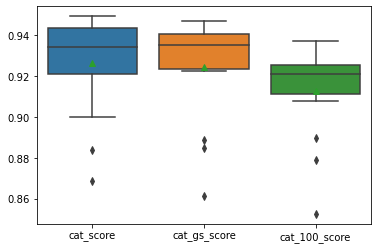

In [22]:
sns.boxplot(data=combo, showmeans=True);

In [23]:
combo.describe()

,cat_score,cat_gs_score,cat_100_score
count,15.000000,15.000000,15.000000
mean,0.926385,0.924391,0.912652
std,0.024378,0.025545,0.022446
min,0.868666,0.861081,0.852461
25%,0.921228,0.923438,0.911306
50%,0.934502,0.935548,0.921072
75%,0.943737,0.940709,0.925630
max,0.949361,0.946964,0.937294
